In [38]:
# Dependencies
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import vlsvtools
import vdfplot

# Bokeh dependencies
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure

from bokeh.core.enums import MarkerType
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, Scatter, MultiChoice, Select
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.models.widgets import Panel, Tabs

from bokeh.palettes import Category10 

output_notebook()

Loading BokehJS ...

In [39]:
# Load file that we want to visualize
CSVFILE = 'output/2D_magnetosphere.csv'
df = pd.read_csv(CSVFILE)
df.head()

,fileid,cellid,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,...,s24_kurt,s24_zeros,mean,zeros,partials,gap,spatial_x,spatial_y,spatial_z,pngfile
0,4000,1,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-599850000.0,0.0,-359850000.0,f0004000c00001.png
1,4000,51,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-584850000.0,0.0,-359850000.0,f0004000c00051.png
2,4000,101,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-569850000.0,0.0,-359850000.0,f0004000c00101.png
3,4000,151,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-554850000.0,0.0,-359850000.0,f0004000c00151.png
4,4000,201,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-539850000.0,0.0,-359850000.0,f0004000c00201.png


In [40]:
# Function that can prepare the data from CSV to DataFrame

def csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=False, pca_variance=0.9):
    df = pd.read_csv(csv_file)
    if pca_transform:
        X = df.drop(["fileid", "cellid", "spatial_x", "spatial_y", "spatial_z", "pngfile"], axis=1)
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=pca_variance)
        pca_res = pca.fit_transform(X)
        kmeans = KMeans(n_clusters=n_classes).fit(pca_res)
    else:
        kmeans = KMeans(n_clusters=n_classes).fit(df[cols].values)
    kmeans_df = pd.DataFrame(df[['fileid', 'cellid', 'spatial_x', 'spatial_y', 'spatial_z', 'pngfile']])
    kmeans_df.insert(2, 'class', kmeans.labels_)

    # Transform classes to strings as Bokeh wants them as strings
    kmeans_df['class'] = ['class_'+str(i) for i in kmeans_df['class']]

    return(kmeans_df)

csv_file = 'output/2D_magnetosphere.csv'
n_classes = 6
cols = ['gap', 'mean', 'zeros', 'partials']
kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols)
kmeans_df_2D

,fileid,cellid,class,spatial_x,spatial_y,spatial_z,pngfile
0,4000,1,class_0,-599850000.0,0.0,-359850000.0,f0004000c00001.png
1,4000,51,class_0,-584850000.0,0.0,-359850000.0,f0004000c00051.png
2,4000,101,class_0,-569850000.0,0.0,-359850000.0,f0004000c00101.png
3,4000,151,class_0,-554850000.0,0.0,-359850000.0,f0004000c00151.png
4,4000,201,class_0,-539850000.0,0.0,-359850000.0,f0004000c00201.png
...,...,...,...,...,...,...,...
2866,4000,7052751,class_0,225150000.0,0.0,345150000.0,f0004000c7052751.png
2867,4000,7052801,class_0,240150000.0,0.0,345150000.0,f0004000c7052801.png
2868,4000,7052851,class_0,255150000.0,0.0,345150000.0,f0004000c7052851.png
2869,4000,7052901,class_0,270150000.0,0.0,345150000.0,f0004000c7052901.png


In [41]:
# Helpful guide to make interactive Jupyter notebooks:
# https://stackoverflow.com/questions/53217654/how-to-get-interactive-bokeh-in-jupyter-notebook

# Visual options for chart
width = 840
height = 600
circle_size = 12

# Data variables, initial values, etc.
csv_file = 'output/2D_magnetosphere.csv'
n_classes = 6
cols = ['gap', 'mean', 'zeros', 'partials']
pca_transform = False
pca_variance = 0.9

# Initialize data
kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols)
source = ColumnDataSource(data=kmeans_df_2D)

# Possible options for K-means
COLS_OPTIONS = ['gap', 'mean', 'zeros', 'partials']

# Create color map for classes
index_cmap = factor_cmap('class', palette=list(Category10[10]),factors=sorted(kmeans_df_2D['class'].unique()))

# Create hover tooltip for single cell
hover = HoverTool(
    tooltips="""
    <div>
        <img
            src="output/2D_magnetosphere/images/smallblob/@pngfile" alt="@cellid"
            style="margin: 0px 0px 10px 0px; border: 1px solid #000; width: 100px; height: 100px;"
        />
        <div style="font-size: 15px; font-weight: bold;">@cellid</div>
        <div style="font-size: 13px; color: #696;">($x, $y)</div>
    </div>
    """
)

# Initialize our plot
p = figure(title = "2D Magnetosphere",  width=width,  height=height, tools=[hover])

# Render the data to scatter plot
p.circle(
    'spatial_x', # X coordinate
    'spatial_z', # Y coordinate
    source=source,
    fill_alpha=1, 
    size=circle_size, 
    fill_color=index_cmap, 
    line_width=0
)

# Add all the sliders and options to the plot

def update_n_classes(attrname, old, new):
    n_classes = new
    kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols)
    source.data = kmeans_df_2D

def update_cols(attrname, old, new):
    if len(new) > 0:
        cols = new
        kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=pca_transform, pca_variance=pca_variance)
        source.data = kmeans_df_2D
    else:
        print("Value change ignored: at least one column needs to be selected!")

def update_pca_transform(attrname, old, new):
    pca_transform = True if new == "ON" else False 
    kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=pca_transform, pca_variance=pca_variance)
    source.data = kmeans_df_2D

def update_pca_variance(attrname, old, new):
    if new > 0:
        pca_variance = new
        kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=pca_transform, pca_variance=pca_variance)
        source.data = kmeans_df_2D
    else:
        print("Value change ignored: variance can't be zero!")

def update_pca_transform(attr, old, new):
    if tabs.active == 1:
        pca_transform = True
    else:
        pca_transform = False
    
    kmeans_df_2D = csv_data_to_bokeh(csv_file, n_classes, cols, pca_transform=pca_transform, pca_variance=pca_variance)
    source.data = kmeans_df_2D

class_slider = Slider(start=1, end=10, value=5, step=1, title="Number of classes")
multi_choice = MultiChoice(value=cols, options=COLS_OPTIONS, title="Selected columns")
pca_slider = Slider(start=0.0, end=1.0, value=pca_variance, step=0.05, title="Explained variance by PCs")

class_slider.on_change('value', update_n_classes)
multi_choice.on_change('value', update_cols)
pca_slider.on_change('value', update_pca_variance)

# Make PCA transform it's own tab
tab_orig = Panel(child=column(multi_choice), title="Original")
tab_pca = Panel(child=column(pca_slider), title="PCA Transform")
tabs_magnetosphere = Tabs(tabs=[ tab_orig, tab_pca ])

tabs_magnetosphere.on_change('active', update_pca_transform)




layout = row(p, column(class_slider, tabs_magnetosphere))

def modify_doc(doc):
    doc.add_root(row(layout, width=900))

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)


In [50]:

# Data loading for spatial progression graph

# Function that can prepare the data from CSV to DataFrame for spatial progression
def csv_data_to_spatial_bokeh(csv_file):
    df = pd.read_csv(SPATIAL_CSVFILE)
    kmeans_1D = KMeans(n_clusters=6).fit(df[cols].values)

    kmeans_df_1D = pd.DataFrame(df[['fileid', 'cellid', 'spatial_x', 'spatial_y', 'spatial_z', 'pngfile']])
    kmeans_df_1D.insert(2, 'class', kmeans.labels_)

    # Transform classes to strings as Bokeh wants them as strings
    kmeans_df_1D['class'] = ['class_'+str(i) for i in kmeans_df['class']]

    return(kmeans_df_1D)

SPATIAL_CSVFILE = 'output/1D_shock_perpendicular.csv'

kmeans_df_1D = csv_data_to_spatial_bokeh(SPATIAL_CSVFILE)

dataset = vlsvtools.VLSVdataset('data')
rhos = dataset.get_rhos()


INFO:vlsvtools:Found 16 files.
INFO:vlsvtools:Found 1200 cells in data/bulk.0000015.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000003.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000002.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000014.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000013.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000005.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000009.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000008.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000004.vlsv
INFO:vlsvtools:Found VDF data in 48 cells
INFO:vlsvtools:Found 1200 cells in data/bulk.0000012.vlsv
INFO:vlsvto

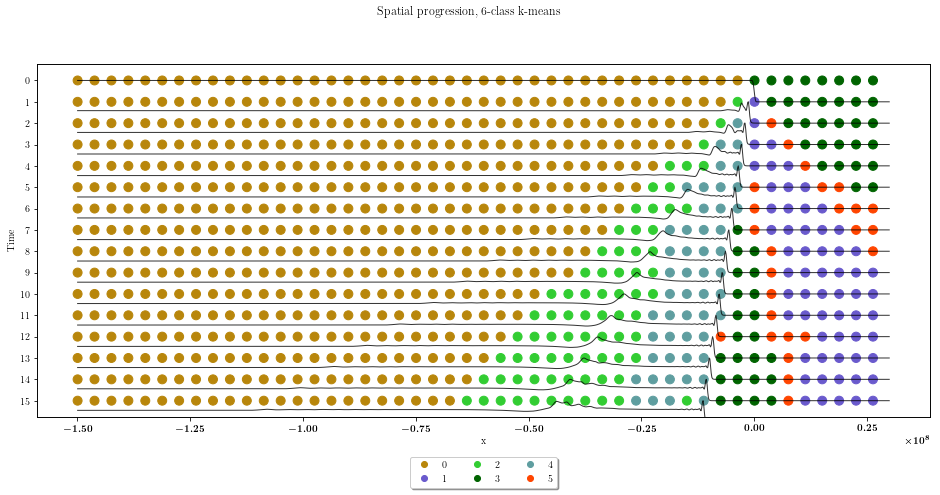

In [44]:

cmap = mpl.colors.ListedColormap(['darkgoldenrod', 'slateblue', 'limegreen', 'darkgreen', 'cadetblue', 'orangered'])
norm = mpl.colors.BoundaryNorm(np.arange(7)-0.5, cmap.N)

fig, ax = plt.subplots(figsize=(16, 8))
for t_idx in range(16):
    snapshot = kmeans_df_1D[kmeans_df_1D['fileid'] == t_idx]
    # Draw balls
    s = ax.scatter(snapshot['spatial_x'], [-t_idx]*len(snapshot), c=snapshot['class'], s=80, cmap=cmap, norm=norm)
    if t_idx == 12:
        legend_handles = s.legend_elements()[0]
ax.set_yticks(range(-15, 1))
ax.set_yticklabels(range(15, -1, -1))
ax.set_ylabel('Time')
ax.set_xlabel('x')

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.axes.yaxis.set_visible(False)

for i in range(16):
    x = rhos[i][:,0]
    rho = rhos[i][:,3]
    # Draw black line on top of the balls
    ax2.plot(x, (rho-1e6) / (rho.max()-1e6) - (i) - 1, color='black', lw=1, alpha=0.8)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.legend(handles=legend_handles, 
           labels=['0', '1', '2', '3', '4', '5'],
           loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)
plt.suptitle('Spatial progression, 6-class k-means')
plt.show()

In [51]:

# Visual options for chart
width = 840
height = 400
circle_size = 10

p = figure(title = "2D Magnetosphere", width=width, height=height)

source = ColumnDataSource(data=kmeans_df_1D)
index_cmap_1D = factor_cmap('class', palette=list(Category10[10]),factors=sorted(kmeans_df_1D['class'].unique()))

# Process rows one-by-one
for t_idx in range(16):
    snapshot = kmeans_df_1D[kmeans_df_1D['fileid'] == t_idx].copy()
    # Make new Y-axis based on which row we are in
    snapshot['new_y'] = [-t_idx] * len(snapshot)
    # Draw balls
    p.circle(
        'spatial_x', # X coordinate
        'new_y', # Y coordinate
        source=ColumnDataSource(data=snapshot),
        fill_alpha=1, 
        size=circle_size, 
        fill_color=index_cmap_1D, 
        line_width=0
    )



# Make PCA transform it's own tab
tab_spatial = Panel(child=column(p), title="Spatial progression of 1D data")
tab_magnetosphere = Panel(child=column(), title="2D magnetosphere")
tabs = Tabs(tabs=[ tab_spatial, tab_magnetosphere ])



layout = tabs #row(p, column(tabs))

def modify_doc(doc):
    doc.add_root(row(layout, width=900))

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)







### 